# Regressions

In a **regrression** problem, the goal is to predict the output of a continuous value, such as a price or a probability. This is quite different from a **classification** problem, where we predict a class from a _discrete_ set of possible classes.

In this example, we will use the **Auto MPG** dataset, which is a slightly modified version of the dataset form StatLib. The dataset contains information about fuel consumption for cars from the 1970s and 1980s (measured in miles per gallon). We will work with 3 discrete and 5 continuous attributes.

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

In [75]:
np.set_printoptions(precision=3, suppress=True) # make NumPy printouts easier to read

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("TensorFlow version installed: ", tf.__version__)

TensorFlow version installed:  2.16.2


In [77]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data' # dataset's url
columns = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin'] # attributes we will work with

rawDataset = pd.read_csv(url, names=columns, na_values = '?', comment='\t', sep=' ', skipinitialspace=True) # read from .csv using pandas
dataset = rawDataset.copy()
dataset.tail() # print some entries

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [78]:
dataset = dataset.dropna() # delete entries with missing data

In our dataset, we have a column caleed _Origin_. This column contains integer values referring to the region of origin of each car. We will need to map each integer to a string (the anme of the region), and then use pandas to encode the values into a boolean set (using [one hot encoding](https://www.geeksforgeeks.org/ml-one-hot-encoding)).



In [79]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep = '')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


Now we can observe that columns have appeared for each region (Europe, Japan, USA) - which take boolean values _True_ or _False_

To train a Machine Learning model, we need to obtain a training dataset and a test dataset. The typical proportion of entries in each dataset is usually **80% training, 20% test**. The training dataset is used to actually train the model, while the test dataset is used to verify its accuracy.<br>
From the training dataset another **20%** of entries are usually taken for validation.

In [80]:
trainDataset = dataset.sample(frac=0.8, random_state=0)
testDataset = dataset.drop(trainDataset.index)

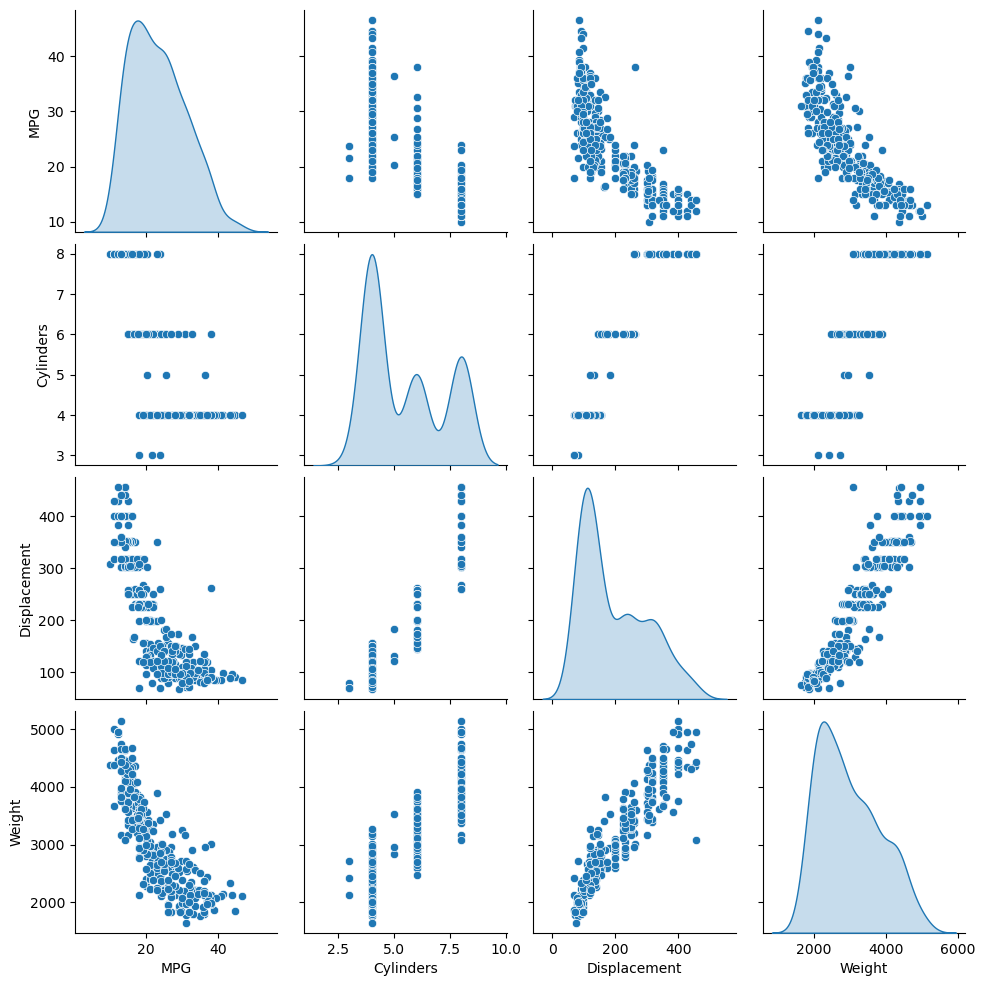

In [81]:
sb.pairplot(trainDataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde') # displaying the distribution of attributes in the training dataset

<b style="color: red">!</b> <b style="color: red">!</b> MPG - Miles per Gallon, also known as **Fuel Efficiency**, is a function that depends on **all** the other parameters (this is evident from the first row of graphs). The other rows suggest that some parameters depend on each other.

In [82]:
trainDataset.describe().transpose() # Display general statistics for each attribute
# We can observe that each attribute is distributed over different intervals
# However, the specific distribution of each attribute is not of interest

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [83]:
trainFeatures = trainDataset.copy()
testFeatures = testDataset.copy()
trainLabels = trainFeatures.pop("MPG")
testLabels = testFeatures.pop("MPG")
# Remove the "MPG" attribute from the datasets - this will be the attribute that we want the model to predict

In [84]:
trainDataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


^ Here we displayed the mean of each attribute, along with the Standard Deviation (std from the function).
Standard Deviation is the σ (lowercase sigma) - which is the square root of the variance of a variable.

$$
\sigma = \sqrt{E(X^2) - (E(X))^2}
$$
where
- $\sigma $  ---  standard deviation
- E(X) --- mean of the variable X

Considering that the distributions of the attributes are so different, we will need to normalize them. <br>In a neural network, each input value is multiplied by a weight, which affects the output. Therefore, it is advisable to normalize (scale) the values so that our model can function correctly and efficiently.
<br><br> <small>*There are exceptions where a model _may_ converge without normalizing the data, but it is preferable to scale the dataset to stabilize the training process.</small>

In [85]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(trainFeatures))
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [86]:
first = np.array(trainFeatures[:1]).astype(np.float32)

with np.printoptions(precision=2, suppress=True):
    print("First example: ", first)
    print()
    print("Normalized: ", normalizer(first).numpy())

First example:  [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized:  [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Linear Regression
Before constructing a deep neural network model, we will start with linear regression using one or more variables.
### Starting with a Single Variable
First, we will attempt to use linear regression to predict _MPG_ from _Horsepower_.<br><br>
Using <a href="https://www.tensorflow.org/api_docs/python/tf/keras">tf.keras</a>, we begin training a model by defining its architecture. Here we will use <a>tf.keras.Sequential</a>.
<br><br>
We will follow 2 steps in the linear regression model with a single variable:
1. Normalize _Horsepower_ using the preprocessing layer <a>tf.keras.layers.Normalization</a>.
2. Apply a linear transformation ($y = mx + b$) to produce a single output using a linear layer, specifically <a>tf.keras.layers.Dense</a>.


In [87]:
horsepower = np.array(trainFeatures['Horsepower'])
horsepowerNormalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepowerNormalizer.adapt(horsepower)

/home/adrifot/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [88]:
horsepowerModel = tf.keras.Sequential([
    horsepowerNormalizer,
    layers.Dense(units=1)
])

horsepowerModel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_21                │ (None, 1)              │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [89]:
horsepowerModel.predict(horsepower[:10]) # We run the *untrained* model on the first 10 horsepower values. The output will, of course, be incorrect - the model has not been trained yet.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([[ 0.008],
       [ 0.004],
       [-0.014],
       [ 0.011],
       [ 0.01 ],
       [ 0.004],
       [ 0.012],
       [ 0.01 ],
       [ 0.003],
       [ 0.004]], dtype=float32)

In [90]:
horsepowerModel.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1),
    loss = 'mean_absolute_error'
)

^ We configure the training procedure for our model using <a>Model.compile</a> from Keras. The important arguments are:
- <span style="color: green">loss</span> <br> Represents what we want to optimize. In our case, the mean absolute error.<br><br>
- <span style="color: green">optimizer</span> <br> Represents the algorithm we will use for optimization. In our case, the Adam algorithm.

In [91]:
%%time

history = horsepowerModel.fit(
    trainFeatures["Horsepower"],
    trainLabels,
    epochs = 100,
    verbose = 0, # supress logging
    validation_split = 0.2 # We take 20% of the training dataset to create a validation dataset.
)

CPU times: user 4.69 s, sys: 217 ms, total: 4.91 s
Wall time: 4.49 s


In [92]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail() # display the progress towards the end of training process.

,loss,val_loss,epoch
95,3.806380,4.201077,95
96,3.803278,4.177625,96
97,3.803715,4.173057,97
98,3.802265,4.195574,98
99,3.807223,4.211442,99


In [93]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 10])
    plt.xlabel("Epoch")
    plt.ylabel("Error [MPG]")
    plt.legend()
    plt.grid(True)

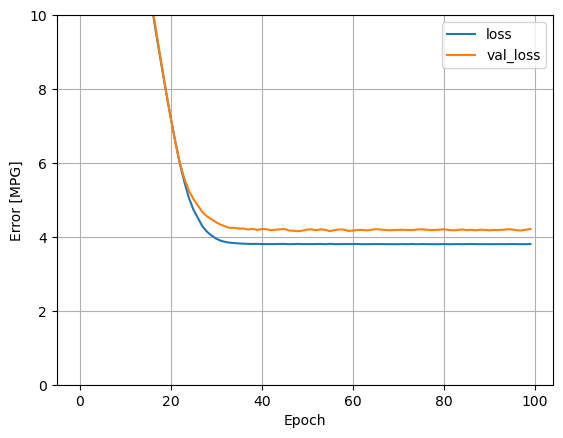

In [94]:
plot_loss(history)

In [95]:
testResults = {}

testResults["horsepowerModel"] = horsepowerModel.evaluate(
    testFeatures["Horsepower"],
    testLabels, verbose=0
)

# Save the results for the test set (we will use them later).

In [96]:
x = tf.linspace(0.0, 250, 251)
y = horsepowerModel.predict(x)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7eff05723e20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [97]:
def plot_horsepower(x, y):
    plt.scatter(trainFeatures["Horsepower"], trainLabels, label="Data")
    plt.plot(x, y, color="k", label="Predictions")
    plt.xlabel("Horsepower")
    plt.ylabel("MPG")
    plt.legend()

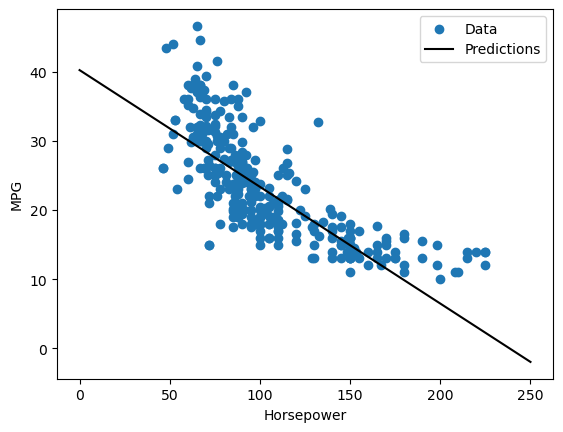

In [98]:
plot_horsepower(x, y)

### Multiple Variable Linear Regression
The setup for predictions based on multiple inputs is almost identical to the previous one. We will use the same activation function $ y = mx + b $ but this time $m$ will be a _matrix_ and $x$ will be a _vector_.<br><br>
We will create a Keras Sequential model in 2 steps, the first layer being a _normalizer_.

In [99]:
linearModel = tf.keras.Sequential([
    normalizer, layers.Dense(units=1)
])

In [100]:
linearModel.predict(trainFeatures[:10].astype(np.float32))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


array([[ 0.886],
       [-0.586],
       [ 1.274],
       [-0.354],
       [-1.054],
       [-0.22 ],
       [-1.07 ],
       [-3.875],
       [ 0.576],
       [-0.075]], dtype=float32)

In [101]:
linearModel.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss = "mean_absolute_error"
)

In [102]:
%%time
history = linearModel.fit(
    trainFeatures.astype(np.float32),
    trainLabels,
    epochs = 100,
    verbose = 0,
    validation_split = 0.2
)

CPU times: user 4.77 s, sys: 268 ms, total: 5.04 s
Wall time: 4.66 s


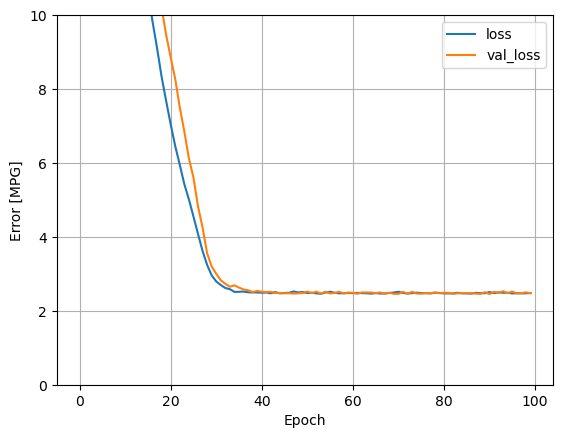

In [103]:
plot_loss(history)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


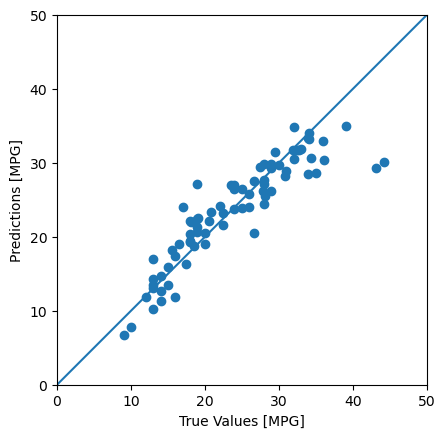

In [104]:
testPredictions = linearModel.predict(testFeatures.astype(np.float32)).flatten()
a = plt.axes(aspect="equal")
plt.scatter(testLabels, testPredictions)
plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [105]:
testResults["linearModel"] = linearModel.evaluate(
    testFeatures.astype(np.float32), testLabels, verbose = 0
)

### Deep Neural Network (DNN) Regression with a Single Variable
So far, we have implemented two linear models: one for a single input and one for multiple inputs.
Now, we can implement **DNN models** for both single-input and multiple-input scenarios.
<br><br>
The code is almost the same. The main change is that we will include multiple "hidden" non-linear layers (which are not directly connected to the input or output).
<br><br>
In these models, we will have the following layers:
- Normalization Layer (as in the previous example)
- Non-Linear Hidden Layers (x2) - these will be _Dense_ layers with the ReLU (**Re**ctified **L**inear **U**nit) activation function
- Linear Dense single-output Layer

Both models will use the same training procedure, so it would be more efficient to build a function for that.

In [106]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [107]:
horsepowerModelDNN = build_and_compile_model(horsepowerNormalizer)
horsepowerModelDNN.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_21                │ (None, 1)              │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [108]:
%%time
history = horsepowerModelDNN.fit(
    trainFeatures["Horsepower"],
    trainLabels,
    validation_split = 0.2,
    verbose=0,
    epochs = 100
)

CPU times: user 5.5 s, sys: 306 ms, total: 5.8 s
Wall time: 5.59 s


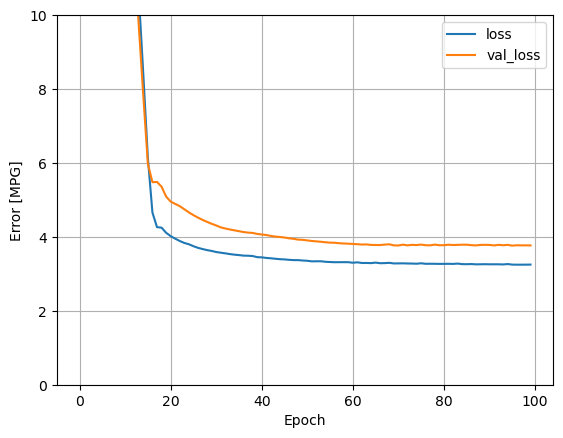

In [109]:
plot_loss(history)

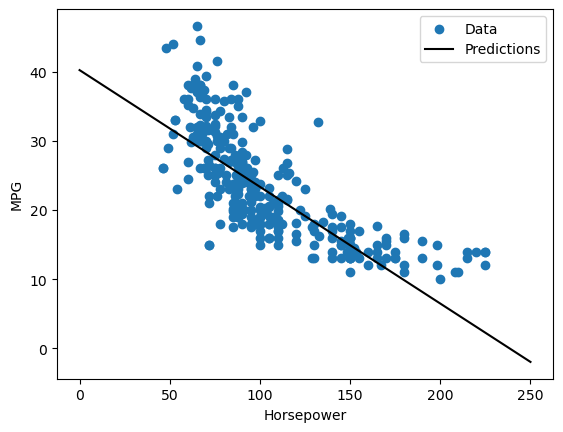

In [110]:
x = tf.linspace(0.0, 250, 251)

plot_horsepower(x, y)

^ As in the example with linear models, we plotted the predictions against inputs. We can observe the effect of the 2 non-linear layers, which significantly increase the accuracy of the model.

In [111]:
testResults["horsepowerModelDNN"] = horsepowerModelDNN.evaluate(
    testFeatures["Horsepower"],
    testLabels,
    verbose = 0
)

### DNN Regression - Multiple Variables

In [112]:
dnnModel = build_and_compile_model(normalizer)
dnnModel.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_20                │ (10, 9)                │            19 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [113]:
%%time
history = dnnModel.fit(
    trainFeatures.astype(np.float32),
    trainLabels,
    epochs = 100,
    verbose = 0,
    validation_split = 0.2
)

CPU times: user 5.54 s, sys: 261 ms, total: 5.8 s
Wall time: 5.29 s


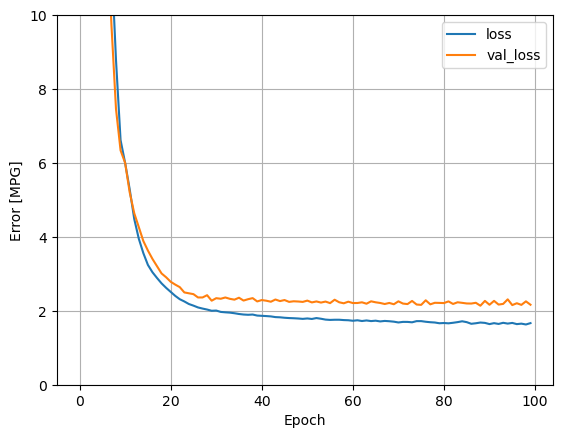

In [114]:
plot_loss(history)

In [115]:
testResults["dnnModel"] = dnnModel.evaluate(testFeatures.astype(np.float32), testLabels, verbose=0)
pd.DataFrame(testResults, index=["Mean absolute error [MPG]"]).T

,Mean absolute error [MPG]
horsepowerModel,3.657897
linearModel,2.457304
horsepowerModelDNN,2.890052
dnnModel,1.736073


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


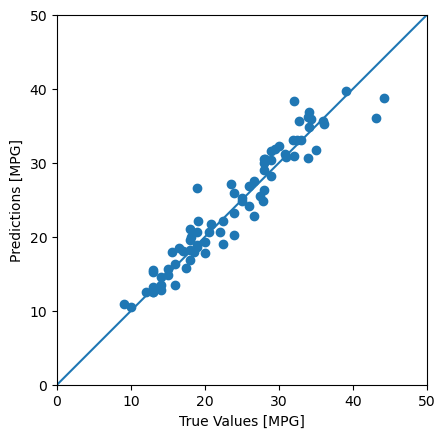

In [116]:
testPredictions = dnnModel.predict(testFeatures.astype(np.float32)).flatten()
a = plt.axes(aspect="equal")
plt.scatter(testLabels, testPredictions)
plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

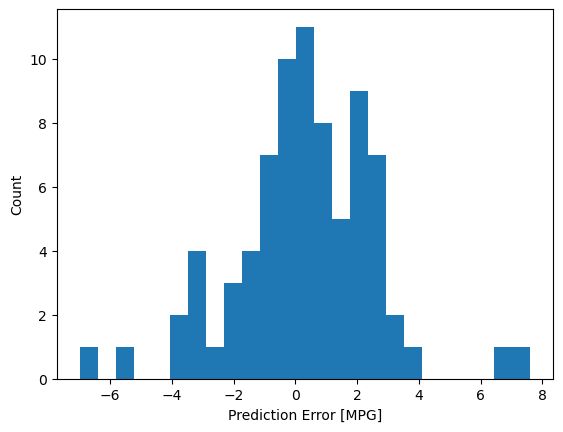

In [117]:
error = testPredictions - testLabels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")